In [1]:
from emle.models import EMLE, ANI2xEMLE, MACEEMLE
from emle_bespoke.patching import EMLEPatched
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from math import sqrt
import time as time

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1830994/2641520974.py:34: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1830994/2641520974.py:35: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1830994/2641520974.py:56: SyntaxWarning: invalid escape sequence '\m'
  axes[1].se

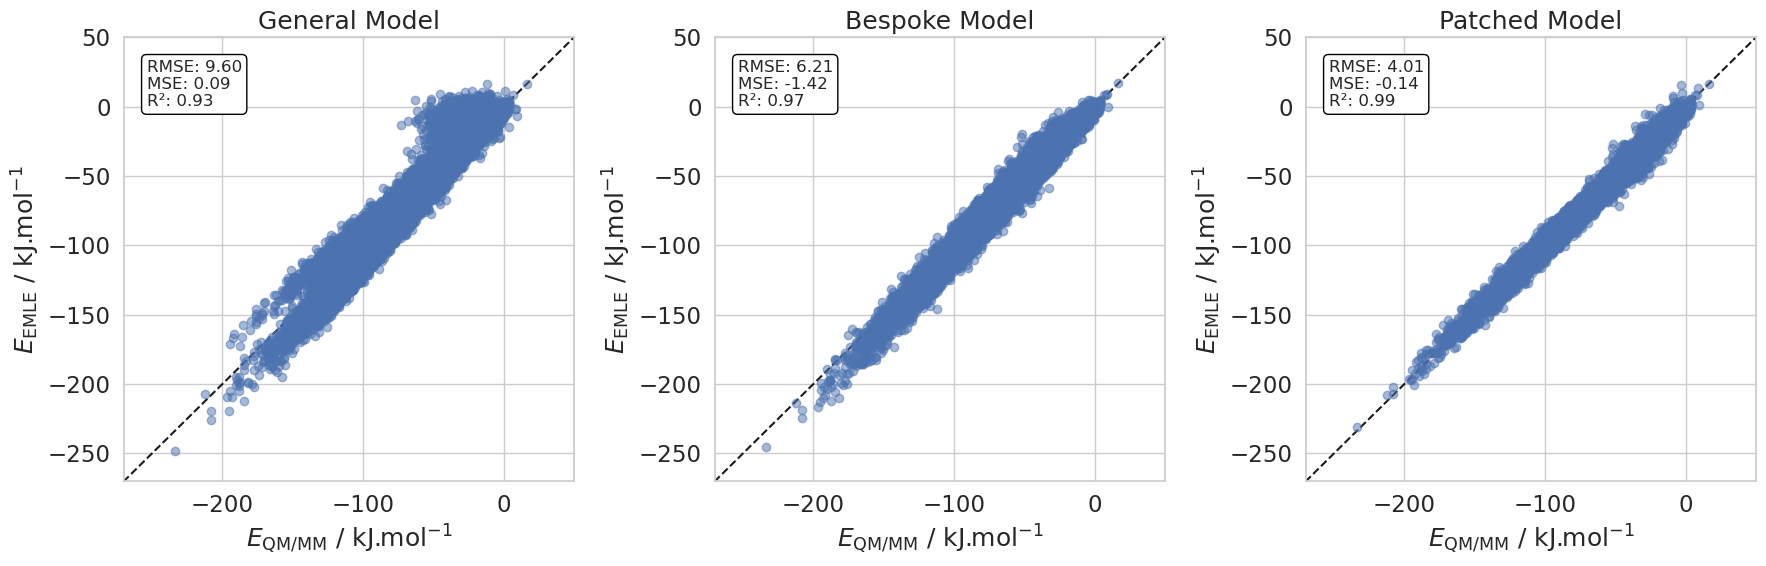

In [14]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", 
        font_scale=1.5)



# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x

# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(predicted_values - true_values)
    rmse = sqrt(np.mean((predicted_values - true_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2

# Set limits for all subplots and plot reference line
xmin, xmax = -270, 50
ymin, ymax = -270, 50
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
general_model = np.loadtxt("/home/joaomorado/repos/emle-bespoke/notebooks/emle_general.txt")
e_static, e_static_emle = general_model[:, 0], general_model[:, 1]
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static, e_static_emle, "o", label="Static", alpha=0.5)
axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_title("General Model")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
general_model = np.loadtxt("/home/joaomorado/repos/emle-bespoke/notebooks/emle_bespoke.txt")
e_ind, e_ind_emle = general_model[:, 0], general_model[:, 1]
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
axes[1].plot(e_ind, e_ind_emle, "o", label="Induction", alpha=0.5)
axes[1].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Bespoke Model")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
general_model = np.loadtxt("/home/joaomorado/repos/emle-bespoke/notebooks/emle_patched.txt")
e, e2 = general_model[:, 0], general_model[:, 1]

rmse_total, mse_total, r2_total = compute_metrics(
    e, e2
)
axes[2].plot(e, e2, "o", label="Total", alpha=0.5)
axes[2].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Patched Model")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()
plt.savefig("emle_models_perf.pdf", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()
